In [32]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
#import torch.nn as torch_nn     # refers to PyTorch's official functions

In [33]:
with open("AeCa.txt",'r',encoding='UTF-8') as f:
    text=f.read()
f.close()

In [34]:
print("Length of the dataset of characters: ",len(text))                                          #Total Length of the text file

Length of the dataset of characters:  1591049


In [35]:
chars=sorted(list(set(text)))                                #Total number of different characters in the DNA sequence
vocab_size=len(chars)
print(chars,vocab_size)

['A', 'C', 'G', 'T'] 4


In [36]:
stoi={s:i for i,s in enumerate(chars)}
itos={i:s for i,s in enumerate(stoi)}
stoi,itos

({'A': 0, 'C': 1, 'G': 2, 'T': 3}, {0: 'A', 1: 'C', 2: 'G', 3: 'T'})

In [37]:
encode=lambda word:[stoi[s] for s in word]
decode=lambda num: ''.join([itos[i] for i in num])

d_en=encode("GTTA")
d_de=decode(d_en)
print(d_en,d_de)

[2, 3, 3, 0] GTTA


In [38]:
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)

torch.Size([1591049]) torch.int64


In [39]:
l=int(0.8*data.shape[0])
h=int(0.9*data.shape[0])
train_data=data[:l]
val_data=data[l:h]
test_data=data[h:]
print(train_data.shape,val_data.shape,test_data.shape)

torch.Size([1272839]) torch.Size([159105]) torch.Size([159105])


In [40]:
block_size=8
train_data[:block_size+1]

tensor([2, 1, 1, 2, 1, 1, 1, 1, 1])

In [41]:
x=train_data[:block_size]
y=train_data[1:block_size+1]
for t in range (block_size):
    context=x[:t+1]
    target=y[t]
    print(f"In the context of {context} the target is {target}")

In the context of tensor([2]) the target is 1
In the context of tensor([2, 1]) the target is 1
In the context of tensor([2, 1, 1]) the target is 2
In the context of tensor([2, 1, 1, 2]) the target is 1
In the context of tensor([2, 1, 1, 2, 1]) the target is 1
In the context of tensor([2, 1, 1, 2, 1, 1]) the target is 1
In the context of tensor([2, 1, 1, 2, 1, 1, 1]) the target is 1
In the context of tensor([2, 1, 1, 2, 1, 1, 1, 1]) the target is 1


In [42]:
class Linear(nn.Module):
    def __init__(self,fan_in,fan_out,bias=False):
        super().__init__()
        self.W=nn.Parameter(torch.randn((fan_out,fan_in)))
        self.b=nn.Parameter(torch.randn(fan_out)) if bias==True else None
    
    def forward(self, x):
        #print(self.W.shape,x.shape)
        out= x @ self.W.T
        if self.b is not None:
            out=out+self.b
        return  out

In [43]:
class ReLu(nn.Module):
    def __init__(self,inplace=False):
        super().__init__()
        self.inplace=inplace

    def forward(self,x):
        if(self.inplace):
            return torch.clamp_(x,min=0.0)      # modifies x
        else:
            return torch.clamp(x,min=0.0)       # x remains unchanged

In [44]:
class Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        out=torch.empty_like(x)
        positive=x>=0
        negative=~positive
        out[positive]=1/(1+torch.exp(-x[positive]))
        exp_x=torch.exp(x[negative])
        out[negative]=exp_x/(1+exp_x)
        return out


In [45]:
class TanH(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        out=torch.empty_like(x)
        positive=x>=0
        negative=~positive
        out[positive]=1-(2/(torch.exp(2*x[positive])+1))
        out[negative]=(2/(torch.exp(-2*x[negative])+1))-1
        return out

In [46]:
class RNN(nn.Module):
    def __init__(self,fan_in,fan_out,bias=True):
        super().__init__()
        self.input_size=fan_in
        self.hidden_size=fan_out
        self.i2h=Linear(fan_in,fan_out,bias)         #input ----> hidden
        self.h2h=Linear(fan_out,fan_out,bias)        #hidden ---> hidden
        self.activation=TanH()
    
    def forward(self, x, h0=None):
        """
        x: (seq_len, batch_size, input_size)
        h0: (batch_size, hidden_size)
        """

        seq_len, batch_size,_=x.shape
        
        if h0 is None:
            h_t=torch.zeros(batch_size, self.hidden_size,device=x.device)
        else:
            h_t=h0
        
        outputs=[]
        for t in range(seq_len):
            x_t=x[t]            #(batch_size,input_size)
            # (batch_size,input_size)  @ (input_size,hidden_size) ----> (batch_size,hidden_size)
            # (batch_size,hidden_size)  @ (hidden_size,hidden_size) ----> (batch_size,hidden_size)
            h_t=self.activation(self.i2h(x_t)+self.h2h(h_t)) # (batch_size,hidden_size) + (batch_size,hidden_size)
            outputs.append(torch.unsqueeze(h_t,dim=0))                  #(batch_size,input_size) ----> (1,batch_size,input_size)
        
        out=torch.cat(outputs,dim=0) #concatenating all the (1,batch_size,input_size) into (seq_len,batch,input_size)
        return  out,h_t.unsqueeze(0)

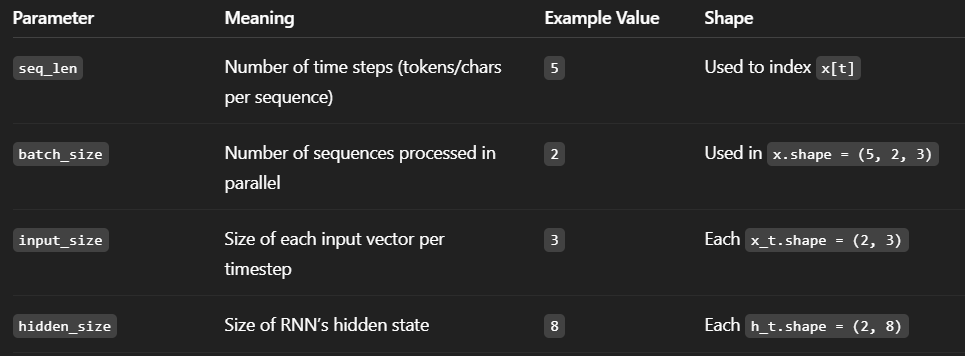

if this is a character level model it is using the last 5 characters taking  3 dimensional input for each charcter and processing in 2 batches //ly

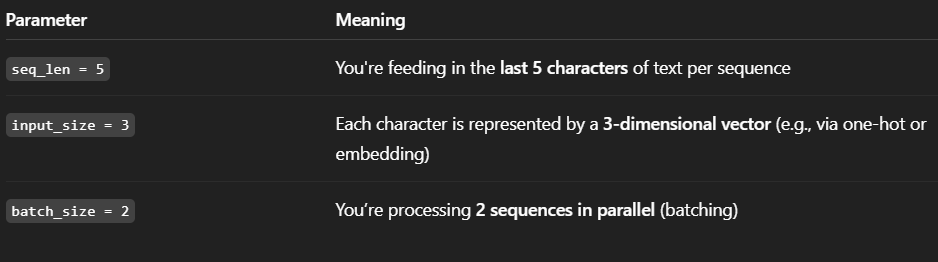

In [47]:
seq_len, batch_size, input_size, hidden_size = 5, 3, 10, 8
x = torch.randn(seq_len, batch_size, input_size)

rnn = RNN(input_size, hidden_size)
out, hn = rnn(x)
#torch.nn.RNN()
print(RNN)
print(out.shape)  # torch.Size([5, 3, 8])
print(hn.shape)   # torch.Size([1, 3, 8])

<class '__main__.RNN'>
torch.Size([5, 3, 8])
torch.Size([1, 3, 8])


In [48]:
x = torch.tensor([-1000.0, 0.0, 1000.0])
l=TanH()
print("Stable:", l(x)) 

Stable: tensor([-1.,  0.,  1.])


In [49]:
x = torch.tensor([-1000.0, 0.0, 1000.0])
k=Sigmoid()
print("Stable:", k(x)) 

Stable: tensor([0.0000, 0.5000, 1.0000])


In [50]:
q=Linear(3,4)
print(type(q))
m=q.to(device=device)
x=torch.randn((4,3)).to(device=device)
print(m(x).shape)
print(x.shape)
print(isinstance(q, nn.Linear))


<class '__main__.Linear'>
torch.Size([4, 4])
torch.Size([4, 3])
False


In [51]:
a=torch.randn((1,4))
print(a)
a[a<0]=0
print(a)
print('same as',a.clamp_(min=0.0))


tensor([[-1.6006,  0.4150,  1.7004, -0.9061]])
tensor([[0.0000, 0.4150, 1.7004, 0.0000]])
same as tensor([[0.0000, 0.4150, 1.7004, 0.0000]])


In [52]:
a=torch.randn((1,4)).to(device)
print(a,torch.relu(a))
k=ReLu().to(device)
print(k(a),a)

tensor([[-0.5056, -1.1735,  1.0867,  0.9159]], device='cuda:0') tensor([[0.0000, 0.0000, 1.0867, 0.9159]], device='cuda:0')
tensor([[0.0000, 0.0000, 1.0867, 0.9159]], device='cuda:0') tensor([[-0.5056, -1.1735,  1.0867,  0.9159]], device='cuda:0')


In [53]:
x = torch.tensor([-2.0, 0.0, 3.0])
positive = x >= 0
print(x)
print(x[positive])


tensor([-2.,  0.,  3.])
tensor([0., 3.])


In [54]:
class Softmax(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim  # dimension over which to apply softmax

    def forward(self, x):
        # Numerical stability: subtract max value along dim before exponentiating
        x_max, _ = torch.max(x, dim=self.dim, keepdim=True)
        x_exp = torch.exp(x - x_max)
        out = x_exp / torch.sum(x_exp, dim=self.dim, keepdim=True)
        return out


In [55]:

# ==== Test Softmax ====
softmax = Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
                    [0.5, 0.2, 0.3]])
print("Input to Softmax:\n", x)
print("Softmax output:\n", softmax(x))
print("Sum along dim=1 (should be 1):\n", softmax(x).sum(dim=1))

Input to Softmax:
 tensor([[1.0000, 2.0000, 3.0000],
        [0.5000, 0.2000, 0.3000]])
Softmax output:
 tensor([[0.0900, 0.2447, 0.6652],
        [0.3907, 0.2894, 0.3199]])
Sum along dim=1 (should be 1):
 tensor([1.0000, 1.0000])


In [56]:
class Dropout(nn.Module):
    def __init__(self, p=0.5, inplace=False):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError("Dropout probability must be between 0 and 1.")
        self.p = p  # probability of dropping a unit
        self.inplace = inplace

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x

        # Create a mask: 1 for keep, 0 for drop
        mask = (torch.rand_like(x) > self.p).float()

        if self.inplace:
            x.mul_(mask).div_(1 - self.p)  # scale to keep expected value
            out = x
        else:
            out = (x * mask) / (1 - self.p)

        return out

In [57]:
# ==== Test Dropout ====
dropout = Dropout(p=0.3)
dropout.train()  # enable dropout mode

y = torch.ones((5, 5))
print("\nInput to Dropout:\n", y)
print("Dropout output (train mode):\n", dropout(y))

dropout.eval()  # disable dropout
print("\nDropout output (eval mode - should be unchanged):\n", dropout(y))


Input to Dropout:
 tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
Dropout output (train mode):
 tensor([[1.4286, 1.4286, 1.4286, 1.4286, 0.0000],
        [1.4286, 1.4286, 1.4286, 0.0000, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286, 1.4286],
        [0.0000, 1.4286, 1.4286, 1.4286, 0.0000],
        [1.4286, 0.0000, 0.0000, 1.4286, 0.0000]])

Dropout output (eval mode - should be unchanged):
 tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [58]:
class Flatten(nn.Module):
    def __init__(self, start_dim=1, end_dim=-1):
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, x):
        nd = x.dim()  # number of dimensions

        # Normalize possibly-negative dims
        start = self.start_dim if self.start_dim >= 0 else nd + self.start_dim
        end   = self.end_dim   if self.end_dim   >= 0 else nd + self.end_dim

        if not (0 <= start < nd) or not (0 <= end < nd):
            raise ValueError(f"start_dim/end_dim out of range for input with dim {nd}")
        if start > end:
            raise ValueError("start_dim must be <= end_dim")

        new_shape = x.shape[:start] + (-1,) + (() if end == nd - 1 else x.shape[end+1:])
        
        return x.reshape(new_shape)

In [59]:
# ==== Test Flatten ====
flatten = Flatten()
z = torch.randn(2, 3, 4, 5)  # shape: (2, 3, 4, 5)
print("\nFlatten test:")
print("Before flatten:", z.shape)
z_flat = flatten(z)
print("After flatten:", z_flat.shape)

# Custom flatten range
flatten_partial = Flatten(start_dim=2, end_dim=3)
z_partial = flatten_partial(z)
print("Partial flatten (dims 2-3):", z_partial.shape)


Flatten test:
Before flatten: torch.Size([2, 3, 4, 5])
After flatten: torch.Size([2, 60])
Partial flatten (dims 2-3): torch.Size([2, 3, 20])


In [60]:
p=0.1
x= torch.ones((5, 5))
mask = (torch.rand_like(x) > p).float()
mask

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.]])

In [61]:
class Head(nn.Module):
    '''a single self attention head'''

    def __init__(self, n_embd, head_size,bias=False):
        super().__init__()
        self.key=Linear(n_embd,head_size,bias)
        self.query=Linear(n_embd,head_size,bias)
        self.value=Linear(n_embd,head_size,bias)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
        self.dropout=Dropout()
        self.softmax=Softmax(dim=-1)

    def forward(self,x):

        B,T,C=x.shape
        k=self.key(x)       # (B,T,hs)
        q=self.query(x)     # (B,T,hs)
        
        # compute attention scores ("affinities")
        wei= q @ k.transpose(-2,-1)*C**(-0.5)                               #(B,T,C) @ (B,C,T) --------> (B,T,T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))         #(B,T,T)
        wei=self.softmax(wei)                                        #(B,T,T)
        wei=self.dropout(wei)
        
        # perform the weighted aggregation of the values
        v=self.value(x)
        out=wei @ v
        print(out.shape)
        return out,wei



In [62]:
n_embd = 64        # Embedding dimension (input size for the linear layers)
head_size = 16     # Head size (output size for the linear layers)
block_size = 8     # Sequence length
batch_size = 4     # Number of sequences in the batch

head = Head(n_embd, head_size)

# Create a random input tensor
x = torch.randn(batch_size, block_size, n_embd)

# Forward pass
out, wei = head(x)

# Print the shapes
print(f"Input shape (x): {x.shape}")
print(f"Output shape (out): {out.shape}")
print(f"Attention weights shape (wei): {wei.shape}")

torch.Size([4, 8, 16])
Input shape (x): torch.Size([4, 8, 64])
Output shape (out): torch.Size([4, 8, 16])
Attention weights shape (wei): torch.Size([4, 8, 8])
